<a href="https://colab.research.google.com/github/HenrySomeCode/DCGAN_fake_face/blob/main/DCGAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

source: 

*   From AI/ML/DL course by Master Linh HUST
*   https://pytorch.org/tutorials/beginner/dcgan_faces_tutorial.html 



In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
zip_path = "/content/drive/MyDrive/AI_ML_DL Course_by_Master_Linh_HUST/week9/Teaching Assistant/week 9/DCGAN/img_align_celeba.zip"

In [3]:
!cp "{zip_path}" . 

In [4]:
!unzip -q  /content/img_align_celeba.zip -d "/content/celeba"

In [5]:
import torch

In [6]:
import matplotlib.pyplot as plt

In [7]:
import numpy as np

In [8]:
import random

In [9]:
import torch.nn as nn

In [10]:

import torchvision.datasets as dset
import torchvision.transforms as transforms
from  torch.utils.data import DataLoader 

In [11]:
import torchvision.utils as vutils

In [12]:
import torch.optim as optim

In [13]:
import matplotlib.animation as animation
from IPython.display import HTML

In [14]:
manualSeed = 999
# print("Random Seed: ", manualSeed)
random.seed(manualSeed)
torch.manual_seed(manualSeed)
# torch.use_deterministic_algorithms(True)

In [15]:
data_path = "/content/celeba"

In [16]:
image_size =64 # in both training and inference phase
batch_size = 128 #??? because batch_size in paper is 128
workers = 2 # ???
nc = 3 # nunmber of channels in training images
nz = 100 #??? size of latent vector, i.e size of generator input 
ngf =64 #??? relates to depth of feature maps in generator
ndf = 64 #??? relates to depth of feature maps in discriminator
num_epochs = 5 #??? 
lr = 0.0002 #??? because learning rate in paper is 0.0002
beta1 =0.5 #??? beta1 hyperparameter for Adam optimizers. In DCGAN paper, this number is 0.5
ngpu = 1 #number of gpu, if this is 0, code will run on CPU. If this is greater than 0, it will run on that number of gpu.


Creating Dataset

In [17]:
# CenterCrop => Cropping image at the center
# ToTensor => convert PIL image (image opened by PIL - Python Imaging Libary) 
# to image Tensor which is the right form for Normalize class
dataset = dset.ImageFolder(root= data_path,
                           transform=transforms.Compose(
                              [transforms.Resize(image_size),
                               transforms.CenterCrop(image_size),
                               transforms.ToTensor(),
                               transforms.Normalize(
                                  #mean
                                  (0.5,0.5,0.5),
                                  #standard devitation
                                  (0.5,0.5,0.5)                                 
                               )]
                           ))

Creating Dataloader

In [18]:
dataloader = DataLoader(dataset, 
                        batch_size=batch_size,
                        shuffle=True,
                        num_workers = workers)

Decide which device is used

In [19]:
torch.cuda.is_available()

True

In [20]:
device = torch.device("cuda:0" if (torch.cuda.is_available() and ngpu >0) else "cpu")

In [21]:
device

device(type='cuda', index=0)

In [22]:
real_batch = next(iter(dataloader))
print(real_batch[0].shape) # images
print(real_batch[1].shape) #labels


torch.Size([128, 3, 64, 64])
torch.Size([128])


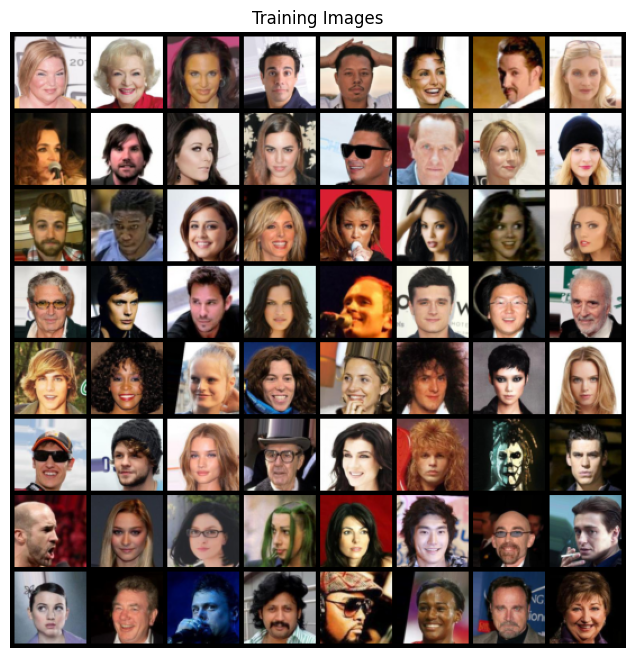

In [23]:
# learn more about iter python at https://www.programiz.com/python-programming/methods/built-in/iter 
real_batch = next(iter(dataloader))
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Training Images")
# real_batch[0] represents images's matrixes, its shape is [128,3,64,64]. 
# real_batch[1] represents images' labels, is shape is [128] 
plt.imshow(
    np.transpose(
        vutils.make_grid(real_batch[0].to(device)[:64], #4D Tensor (Batch x C x H x W)
                         padding=4,
                         normalize=True # shift the image to the range (0,1) using minmax scale 
                         ).cpu(), # ???
         (1,2,0))
    )

Weight Initialization

From the DCGAN paper, the authors point out that all model weights should be randomly initialized from a normal distribution with mean = 0, stdev = 0.02.

The weights_init function takes a model as an input and reinitializes all convolution, transposed convolution, and batch-norm layers to the above criteria. 

In [24]:
def weights_init(m):
  classname = m.__class__.__name__
  if classname.find('Conv') != -1:
    #mean = 0.0, standard devitation = 0.02
    nn.init.normal_(m.weight.data,0.0,0.02)
  elif classname.find('BatchNorm')!=-1:
    nn.init.normal_(m.weight.data,0.0,0.02)
    nn.init.constant_(m.bias.data,0)

Creating Generator Model

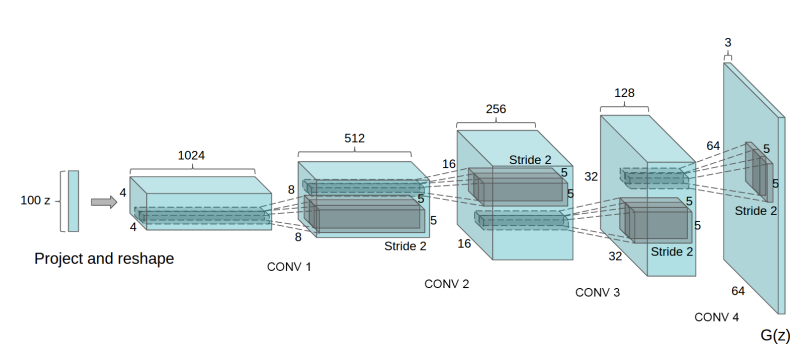

Notice: Above image is used just for representation. We do not implement the project and reshape layer here. In fact, I think this step contains a Dense Layer (1024 *4 *4 neural) and a Reshape Layer(1024, 4, 4) to turn the noise vector into a 1024 x4 x4 tensor. See here for more: 
*   https://towardsdatascience.com/dcgans-deep-convolutional-generative-adversarial-networks-c7f392c2c8f8 
*   https://datascience.stackexchange.com/questions/114844/confusion-on-dcgan-generator-project-reshape 


In [25]:
class Generator(nn.Module):
  def __init__(self,ngpu):
      super(Generator,self).__init__()
      self.ngpu = ngpu
      self.main = nn.Sequential(
          # Z (100x1) => transposed-conv: 512x4x4 => batch-norm + reLu
          # Transpoed-conv formula: W_out = (W_in-1)*S+F+P with S: Stride, F: Filter, P: padding
          nn.ConvTranspose2d(nz,ngf*8,4,1,0,bias=False),
          nn.BatchNorm2d(ngf*8),
          nn.ReLU(True),   
          #512x4x4 => 256x8x8 =>batch-norm + relu
          nn.ConvTranspose2d(ngf*8,ngf*4,4,2,1,bias=False),
          nn.BatchNorm2d(ngf*4),
          nn.ReLU(True),  
          #256x8x8 => 128x16x16 =>batch-norm + relu
          nn.ConvTranspose2d(ngf*4,ngf*2,4,2,1,bias=False),
          nn.BatchNorm2d(ngf*2),
          nn.ReLU(True),  
          #128x16x16 => 64x32x32 =>batch-norm + relu
          nn.ConvTranspose2d(ngf*2,ngf,4,2,1,bias=False),
          nn.BatchNorm2d(ngf),
          nn.ReLU(True),
          #64x32x32 => 3x64x64 =>Tanh (range (1,-1) here's an image of tanh plot: https://miro.medium.com/v2/resize:fit:1190/1*f9erByySVjTjohfFdNkJYQ.jpeg)
          nn.ConvTranspose2d(ngf,nc,4,2,1,bias=False),
          nn.Tanh()
      )
  def forward(self,input):
    return self.main(input)

In [26]:
netG = Generator(ngpu).to(device)
# Handle multi-GPu if desired, since I don't need do I'll comment this
# if (device.type == 'cuda') and (ngpu > 1):
#     netG = nn.DataParallel(netG, list(range(ngpu)))

# Using weights_init function created above to initialize all weights 
# with mean = 0, and std = 0.02
netG.apply(weights_init)
netG

Generator(
  (main): Sequential(
    (0): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace=True)
    (12): ConvTranspose2d(64, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (13): Tanh()
  )
)

Creating Discriminator Model

In [27]:
from torch.nn.modules.batchnorm import BatchNorm2d
class Discriminator(nn.Module):
    def __init__(self, ngpu):
        super(Discriminator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            # 3x64x64 => 64x32x32 => leaky relu . Why not batch-norm here ???
            # Convolution Formula : W_out = (W_in + 2P - K)/S + 1
            nn.Conv2d(nc, ndf, 4,2,1, bias=False),
            nn.LeakyReLU(0.2, inplace=True), # 0.2 is taken from paper
            # 64x32x32 => 128x16x16 => batch-norm + leaky relu 
            nn.Conv2d(ndf, ndf*2, 4,2,1, bias=False),
            nn.BatchNorm2d(ndf*2),
            nn.LeakyReLU(0.2, inplace=True), 
            # 128x16x16 => 256x8x8 => batch-norm + leaky relu 
            nn.Conv2d(ndf*2, ndf*4, 4,2,1, bias=False),
            nn.BatchNorm2d(ndf*4),
            nn.LeakyReLU(0.2, inplace=True),
            # 256x8x8 => 512x4x4 => batch-norm + leaky relu 
            nn.Conv2d(ndf*4, ndf*8, 4,2,1, bias=False),
            nn.BatchNorm2d(ndf*8),
            nn.LeakyReLU(0.2, inplace=True),
            # 512x4x4 =>1x1x1 => sigmoid 
            nn.Conv2d(ndf*8, 1, 4,1,0, bias=False),
            nn.Sigmoid()
            )
    def forward(self,input):
        return self.main(input)


In [28]:
netD = Discriminator(ngpu).to(device)
# Handle multi-GPu if desired, since I don't need do I'll comment this
# if (device.type == 'cuda') and (ngpu > 1):
#     netG = nn.DataParallel(netG, list(range(ngpu)))

netD.apply(weights_init)
netD

Discriminator(
  (main): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (6): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (9): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
    (11): Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (12): Sigmoid()
  )
)

Loss Functions and Optimizers

In [29]:
criterion = nn.BCELoss() # ???
fixed_noise = torch.randn(64,nz,1,1,device = device)
real_label = 1
fake_label = 0
optimizerD = optim.Adam(netD.parameters(),lr=lr, betas=(beta1,0.999)) # betas ???
optimizerG = optim.Adam(netG.parameters(),lr=lr, betas=(beta1,0.999))


Training

I. Training the discriminator model

The goal of this phase is to maximize the equation log(D(x) + log(1-D(G(z)). Or alternatively, minimizing -log(D(x) - log(1-D(G(z))

So firstly, pass the 128 real image batch to the discriminator model loss, i.e., BCE loss.

The BCE loss is -y*log(x) - (1-y)*log(1-x). In our case, y = 1 (real) or 0 (fake), and x is the D(x). Since we just put 128 real images into the discriminator model, which means y=1, the BCE loss should be -log(D(x).

Next, I pass the 128 fake image batch created by the current generator model to the discriminator model. This means y = 0, BCE loss should be -log(1-D(G(z)).

The total loss for the discriminator model is equal to both losses above plus together. 

After getting the loss function, I should update weights. But what should I do to update weights? Uh...Optimizer? 

Yes, but I need more. I need both the optimizer and loss function or, more precisely, both optimizer and gradients in a back-propagation calculated from the loss function. 

For that reason, in each loss calculating step above, after calculating the loss function, I do backward to calculate gradients. 

After that, I use Adam Optimizer to update weights.

II. Training generator model

The goal of this phase is to minimize log(1-D(G(z)), which means maximizing log(D(G(z)) or minimizing - log(D(G(z)).

Now I pass fake images created by the generator once again through the discriminator, but this time is updated. 

The BCE loss is -ylog(x) - (1-y)log(1-x). In this case, y = 1 (fake) or 0 (real) since the generator model wants to make fake images similar to real ones. 

BCE loss should be -log(G(z). After this, calculate the gradients of the generator model in a backward pass and update its weights using Adam Optimizer.


In [30]:
# This can't be done since I'm loading the whole data into the all_batch variable instead 
# of walkign through each of it. The error given is 'It is possible that dataloader's workers 
# are out of shared memory. Please try to raise your shared memory limit.'
# all_batch = list(enumerate(dataloader,0))
# all_batch

In [31]:
# first_batch = all_batch[0]
# first_batch

In [32]:
# This will work instead 
# for i,data in enumerate(dataloader,0):
#     real_cpu = data[0].to(device)
#     print(real_cpu)
#     print(real_cpu.size())# torch.Size([128, 3, 64, 64])
#     b_size = real_cpu.size(0)
#     label = torch.full((b_size,), real_label, dtype=torch.float, device=device)
#     print(label)
#     break

In [ ]:
img_list = []
G_losses = []
D_losses = []
iters = 0

print("Start training loop >>>")
#for each epoch
for epoch in range (num_epochs):
    #for each batch. Can study about enumerate at https://www.geeksforgeeks.org/enumerate-in-python/  
    for i,data in enumerate(dataloader,0):
        # Update Discriminator model by maximize log(D(x))+log(1-D(G(z)))
        # Firstly, put in all real images so that we get the first part of the D loss fucntion, i.e log(D(x))
        netD.zero_grad() # set all gradients to zero
        real_cpu = data[0].to(device) # The name real_cpu is kinda confusing, my opinion is that it should be sth like real_image 
        b_size = real_cpu.size(0) # 128
        label = torch.full(
            (b_size,),
            real_label,
            dtype=torch.float, 
            device = device
        ) # create a tensor with all values = 1 (real label)
        output = netD(real_cpu).view(-1) # study about view() at https://pytorch.org/docs/stable/generated/torch.Tensor.view.html 
        errD_real = criterion(output, label)
        # Calculate gradients for D in backward pass
        errD_real.backward()
        D_x = output.mean().item()

        ## Train with all-fake batch
        # Generate batch of latent vectors
        noise = torch.randn(b_size, nz, 1, 1, device=device)
        # Generate fake image batch with G
        fake = netG(noise)
        label.fill_(fake_label)
        # Classify all fake batch with D
        output = netD(fake.detach()).view(-1)
        # Calculate D's loss on the all-fake batch
        errD_fake = criterion(output, label)
        # Calculate the gradients for this batch, accumulated (summed) with previous gradients
        errD_fake.backward()
        D_G_z1 = output.mean().item()
        # Compute error of D as sum over the fake and the real batches
        errD = errD_real + errD_fake
        # Update D : How does the optimizer update weights without knowing what is the loss function?
        # My personal answer: This might be done through errD_fake.backward() and errD_real.backward()
        optimizerD.step() 

        # Update generator model by minimizing log(1-D(G(z))) or in other word maximizing log(D(G(z)))
        netG.zero_grad()
        label.fill_(real_label)  # fake labels are real for generator cost
        # Since we just updated D, perform another forward pass of all-fake batch through D
        output = netD(fake).view(-1)
        # Calculate G's loss based on this output
        errG = criterion(output, label)
        # Calculate gradients for G
        errG.backward()
        D_G_z2 = output.mean().item()
        # Update G
        optimizerG.step()
        
        # Output training stats
        if i % 50 == 0:
            print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f'
                  % (epoch, num_epochs, i, len(dataloader),
                     errD.item(), errG.item(), D_x, D_G_z1, D_G_z2))
        
        # Save Losses for plotting later
        G_losses.append(errG.item())
        D_losses.append(errD.item())
        
        # Check how the generator is doing by saving G's output on fixed_noise
        if (iters % 500 == 0) or ((epoch == num_epochs-1) and (i == len(dataloader)-1)):
            with torch.no_grad():
                fake = netG(fixed_noise).detach().cpu()
            img_list.append(vutils.make_grid(fake, padding=2, normalize=True))
            
        iters += 1



Start training loop >>>
[0/5][0/1583]	Loss_D: 1.3877	Loss_G: 0.7087	D(x): 0.5027	D(G(z)): 0.5033 / 0.4923
[0/5][50/1583]	Loss_D: 0.0949	Loss_G: 3.0289	D(x): 0.9613	D(G(z)): 0.0538 / 0.0484
[0/5][100/1583]	Loss_D: 0.0270	Loss_G: 4.2580	D(x): 0.9890	D(G(z)): 0.0159 / 0.0142
[0/5][150/1583]	Loss_D: 0.1520	Loss_G: 4.9594	D(x): 0.9887	D(G(z)): 0.1311 / 0.0070
[0/5][200/1583]	Loss_D: 0.0665	Loss_G: 5.2210	D(x): 0.9781	D(G(z)): 0.0428 / 0.0055
[0/5][250/1583]	Loss_D: 0.0263	Loss_G: 5.4654	D(x): 0.9941	D(G(z)): 0.0201 / 0.0044
[0/5][300/1583]	Loss_D: 0.5500	Loss_G: 2.8325	D(x): 0.7269	D(G(z)): 0.1498 / 0.0645
[0/5][350/1583]	Loss_D: 0.4586	Loss_G: 4.5554	D(x): 0.8809	D(G(z)): 0.2285 / 0.0208
[0/5][400/1583]	Loss_D: 0.3238	Loss_G: 3.0221	D(x): 0.8503	D(G(z)): 0.1402 / 0.0507
[0/5][450/1583]	Loss_D: 0.6586	Loss_G: 3.0841	D(x): 0.8542	D(G(z)): 0.3631 / 0.0511
[0/5][500/1583]	Loss_D: 0.9069	Loss_G: 3.0699	D(x): 0.7809	D(G(z)): 0.4571 / 0.0591
[0/5][550/1583]	Loss_D: 0.4631	Loss_G: 2.5098	D(x): 0.8

In [ ]:
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_losses,label="G")
plt.plot(D_losses,label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [ ]:
fig = plt.figure(figsize=(8,8))
plt.axis("off")
ims = [[plt.imshow(np.transpose(i,(1,2,0)), animated=True)] for i in img_list]
ani = animation.ArtistAnimation(fig, ims, interval=1000, repeat_delay=1000, blit=True)

HTML(ani.to_jshtml())

Real vs Fake Images

In [ ]:
# Plot the real images
real_batch = next(iter(dataloader))
plt.figure(figsize=(15,15))
plt.subplot(1,2,1)
plt.axis("off")
plt.title("Real Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=5, normalize=True).cpu(),(1,2,0)))

# Plot the fake images from the last epoch
plt.subplot(1,2,2)
plt.axis("off")
plt.title("Fake Images")
plt.imshow(np.transpose(img_list[-1],(1,2,0)))
plt.show()